In [1]:
# Goal: Verification of the oxygen model using the model spectra from the Jerkstrand+2014 paper

In [2]:
import sys, os, shelve, glob
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.analysis.oxygen as oxygen
import snelib19odp.blackbody as blackbody
import snelib19odp.specds as specds

In [3]:
def flux2luminosity(flux, distance):
    # all in cgs units
    return flux * 4 * np.pi * distance**2

In [4]:
s = table.Table.read('../data/comparison/Jerkstrand2014/15msun/mzams15_250d.dat', format='ascii')
s['restwave'] = s['col1'] + 15
s['flux'] = s['col2']
s

<Table length=4136>
  col1           col2          restwave          flux         
float64        float64         float64         float64        
------- ---------------------- -------- ----------------------
  400.0                    0.0    415.0                    0.0
  400.4                    0.0    415.4                    0.0
  400.8                    0.0    415.8                    0.0
  401.2                    0.0    416.2                    0.0
  401.6                    0.0    416.6                    0.0
  402.0                    0.0    417.0                    0.0
 402.41                    0.0   417.41                    0.0
 402.81                    0.0   417.81                    0.0
 403.21                    0.0   418.21                    0.0
 403.61                    0.0   418.61                    0.0
    ...                    ...      ...                    ...
24654.0  4.066681658302688e-17  24669.0  4.066681658302688e-17
24679.0  4.013803663554216e-17  24694.0  4.013803663554216e-17
24704.0 4.0308900039559793e-17  24719.0 4.0308900039559793e-17
24728.0 3.9124203234414856e-17  24743.0 3.9124203234414856e-17
24753.0  3.673033192679439e-17  24768.0  3.673033192679439e-17
24778.0 3.3226926383837443e-17  24793.0 3.3226926383837443e-17
24802.0  2.822809945648083e-17  24817.0  2.822809945648083e-17
24827.0 2.5144530395547234e-17  24842.0 2.5144530395547234e-17
24852.0 2.2923435964062536e-17  24867.0 2.2923435964062536e-17
24877.0 1.5805600988789667e-17  24892.0 1.5805600988789667e-17

(-5e-16, 5e-16)

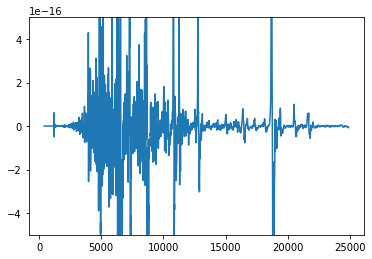

In [5]:
# estimate scale factor
plt.plot(s['restwave'][1:], np.diff(s['flux']))
plt.ylim((-0.05e-14, 0.05e-14))

In [6]:
spec = s[~np.isnan(s['flux'])]
spec

<Table length=4136>
  col1           col2          restwave          flux         
float64        float64         float64         float64        
------- ---------------------- -------- ----------------------
  400.0                    0.0    415.0                    0.0
  400.4                    0.0    415.4                    0.0
  400.8                    0.0    415.8                    0.0
  401.2                    0.0    416.2                    0.0
  401.6                    0.0    416.6                    0.0
  402.0                    0.0    417.0                    0.0
 402.41                    0.0   417.41                    0.0
 402.81                    0.0   417.81                    0.0
 403.21                    0.0   418.21                    0.0
 403.61                    0.0   418.61                    0.0
    ...                    ...      ...                    ...
24654.0  4.066681658302688e-17  24669.0  4.066681658302688e-17
24679.0  4.013803663554216e-17  24694.0  4.013803663554216e-17
24704.0 4.0308900039559793e-17  24719.0 4.0308900039559793e-17
24728.0 3.9124203234414856e-17  24743.0 3.9124203234414856e-17
24753.0  3.673033192679439e-17  24768.0  3.673033192679439e-17
24778.0 3.3226926383837443e-17  24793.0 3.3226926383837443e-17
24802.0  2.822809945648083e-17  24817.0  2.822809945648083e-17
24827.0 2.5144530395547234e-17  24842.0 2.5144530395547234e-17
24852.0 2.2923435964062536e-17  24867.0 2.2923435964062536e-17
24877.0 1.5805600988789667e-17  24892.0 1.5805600988789667e-17

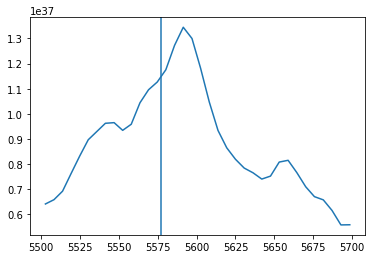

In [7]:
dist_mpc = 5.5
dist_cm = dist_mpc * 1e6 * u.pc.to(u.cm)
idx = np.logical_and(spec['restwave'] > 5500, spec['restwave'] < 5700)
plt.plot(spec['restwave'][idx], flux2luminosity(spec['flux'][idx], dist_cm))
plt.axvline(5577)

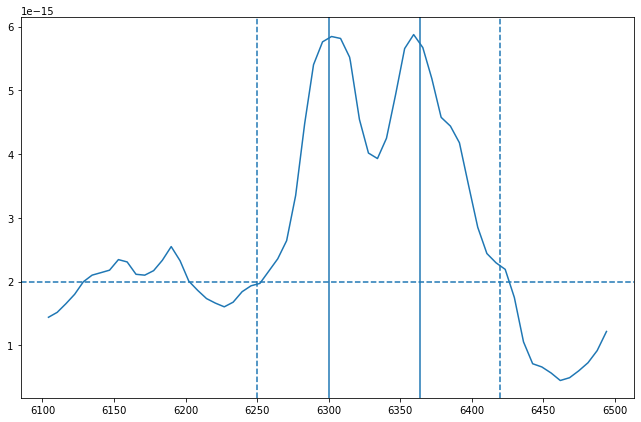

In [8]:
plt.figure(figsize=(11,7))

idx = np.logical_and(spec['restwave'] > 6100, spec['restwave'] < 6500)
#idx = np.logical_and(spec['restwave'] > 6100, spec['restwave'] < 6200)
plt.plot(spec['restwave'][idx], spec['flux'][idx])
plt.axvline(6300)
plt.axvline(6364)
plt.axvline(6250, ls='--')
plt.axvline(6420, ls='--')
plt.axhline(2e-15, ls='--')

In [9]:
idx = np.logical_and(spec['restwave'] > 6250, spec['restwave'] < 6420)
int_flux = np.trapz(spec['flux'][idx], spec['restwave'][idx])
print('Integrated Flux: %e' % int_flux)
cont_flux = np.trapz(2e-15 * np.ones(len(spec['flux'][idx])), spec['restwave'][idx])
print('Estimated Continuum: %e' % cont_flux)
cor_flux = int_flux - cont_flux
print('Contsub Flux: %e' % cor_flux)
lum = flux2luminosity(cor_flux, dist_mpc*1e6*u.pc.to(u.cm))
print('Lum: %e' % lum)

Integrated Flux: 7.087377e-13
Estimated Continuum: 3.302000e-13
Contsub Flux: 3.785377e-13
Lum: 1.370078e+39


In [10]:
cfg = oxygen.FitSetup(spec=spec, smp=1, start5577=5400, stop5577=5700, start6300_6364=6200, stop6300_6364=6420, extra_lines=np.array([]), max_width=25, scale_factor=1e18, max_continuum=1e-14, nlte_mode=0, nlte_departure_max=0.5)

In [11]:
dist_mpc = 5.5
dist_mpc_err = 0.1
dist_min = (dist_mpc-dist_mpc_err) * u.pc.to(u.cm) * 1e6
dist_max = (dist_mpc+dist_mpc_err) * u.pc.to(u.cm) * 1e6
dist_range = (dist_min, dist_max)
#redshift2distance = utils.redshift2distance
results, samples = oxygen.run_dynesty_fit(cfg, dist_range=dist_range)

42201it [05:08, 136.69it/s, batch: 4 | bound: 337 | nc: 25 | ncall: 1008587 | eff(%):  4.184 | loglstar: -563.297 < -556.677 < -558.141 | logz: -585.870 +/-  0.225 | stop:  0.970]       


	Mean: array([ 3.74680857e+00,  3.92842950e+03,  2.24369413e+01,  1.99638745e+03,
        1.75768710e+03, -6.24904032e-05, -2.05091293e-05,  1.69631424e+25,
       -4.87867386e+00,  2.28360638e+00, -2.22762986e+00,  1.00000000e+00])
	Cov: array([[ 1.32550686e+00, -1.21541281e+02, -3.58610597e-02,
		         1.68861249e+00, -3.38886008e+00, -6.34299681e-05,
		         2.72188035e-05,  1.24092509e+22,  1.34120959e-01,
		         2.16792359e-01, -3.70351405e-03,  2.26248227e-29],
		       [-1.21541281e+02,  1.42271787e+04,  1.18572727e+01,
		        -9.43900837e+02,  3.21914339e+02,  4.10008127e-03,
		        -5.82059591e-04, -4.63891708e+23, -9.11286945e+00,
		        -1.69880634e+01,  3.79988023e-01,  1.23688893e-27],
		       [-3.58610597e-02,  1.18572727e+01,  9.39385814e-01,
		        -8.39203162e+00, -2.62968814e+01,  8.63606533e-05,
		         3.12654998e-05, -1.04438198e+21, -9.78166111e-02,
		        -9.48599424e-03, -1.72773461e-03, -4.10245253e-28],
		       [ 1.68861249e+00, -

/home/welterde/.local/lib/python3.8/site-packages/dynesty/plotting.py:1199: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(span[i])
/home/welterde/.local/lib/python3.8/site-packages/dynesty/plotting.py:2238: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  ax.set_ylim(span[1])


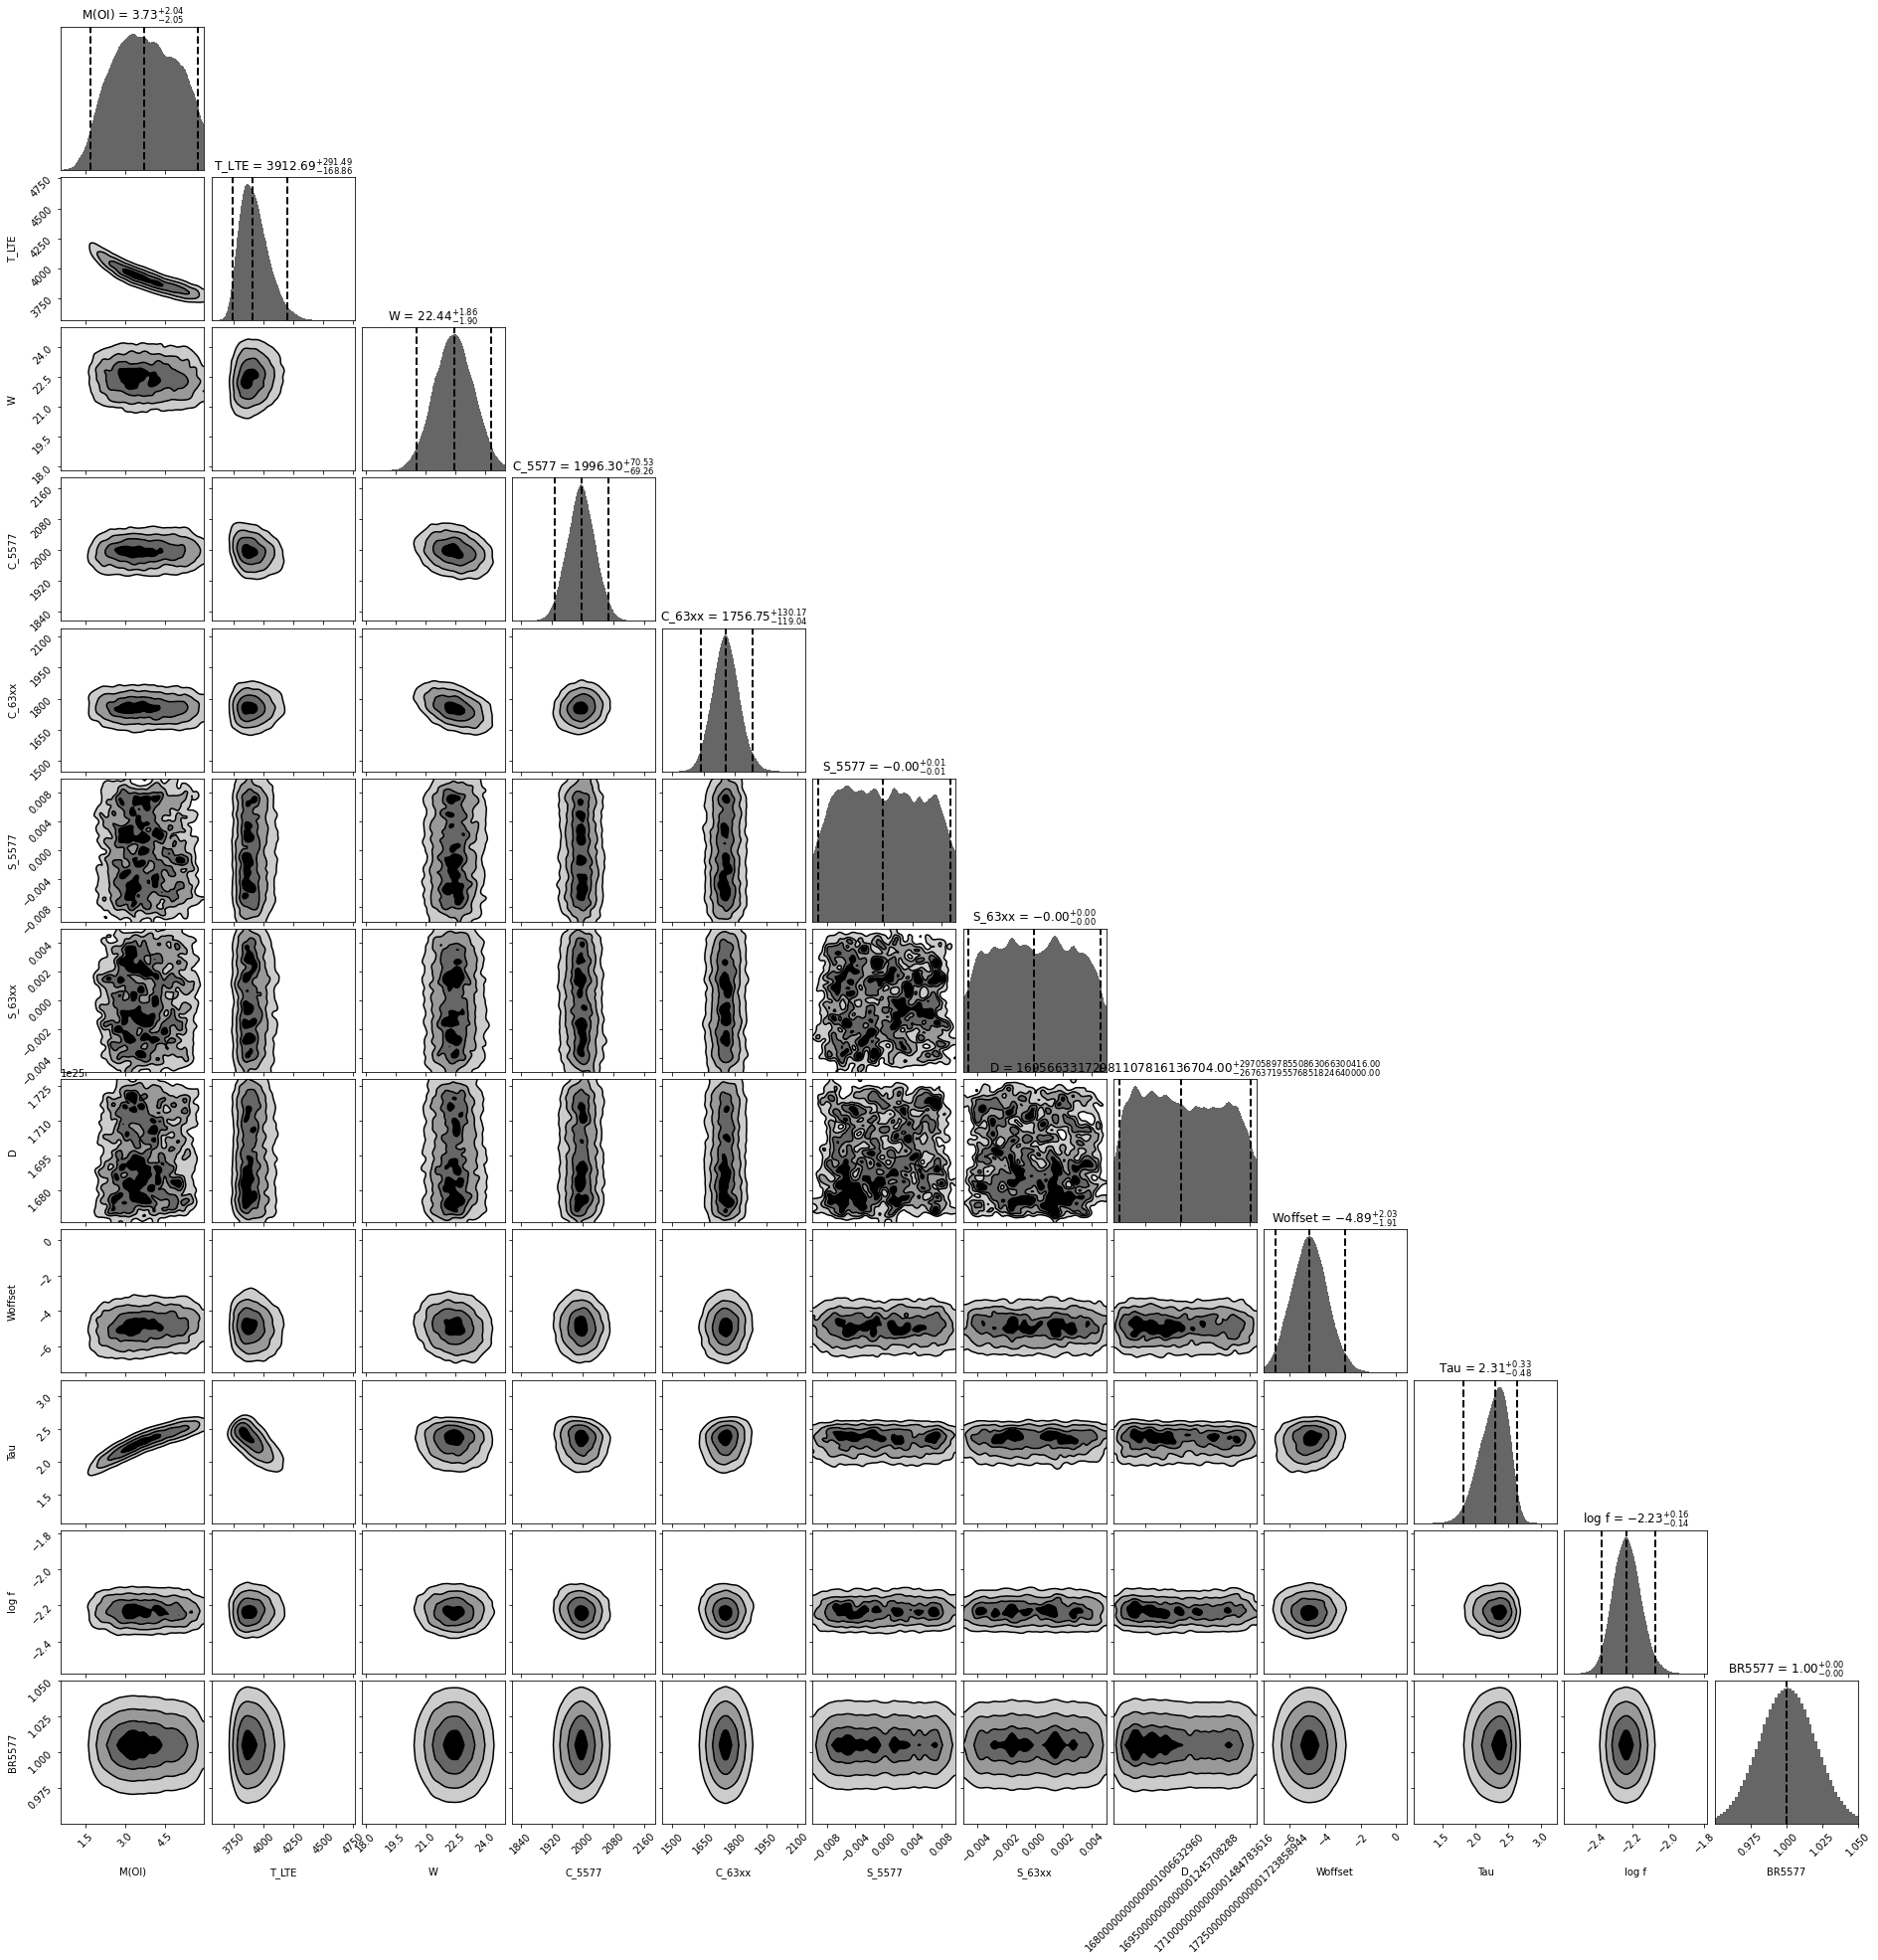

In [12]:
LABELS = ['M(OI)', 'T_LTE', 'W', 'C_5577', 'C_63xx', 'S_5577', 'S_63xx', 'D', 'Woffset', 'Tau', 'log f', 'BR5577', 'AmpE1', 'AmpE2', 'AmpE3', 'AmpE4']
_=dyplot.cornerplot(results, labels=LABELS, show_titles=True)

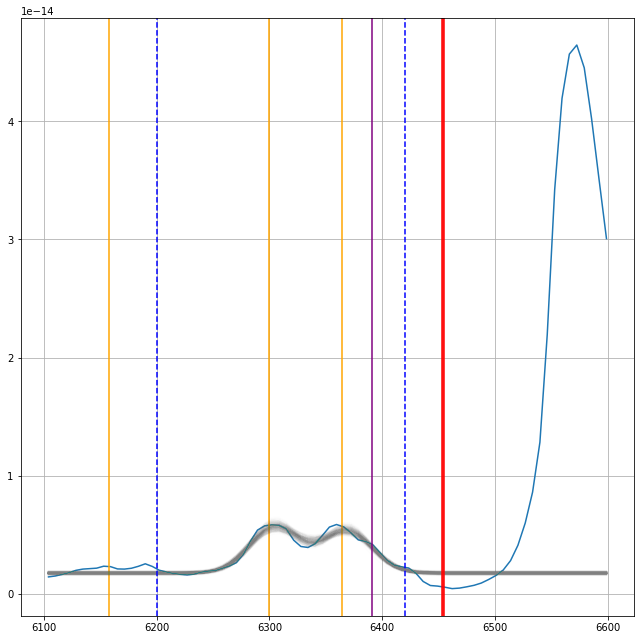

In [13]:
plt.figure(figsize=(11,11))

idx = np.logical_and(spec['restwave'] > 6100, spec['restwave'] < 6600)
#idx = np.logical_and(spec['restwave'] > 6100, spec['restwave'] < 6200)
plt.plot(spec['restwave'][idx], spec['flux'][idx])
#continuum_level_6300_6364 = 0.3e-17
#continuum_slope_6300_6364 = 0.03/1e18
#amplitude_6300 = 1.3e-15
#amplitude_6364 = 0.5e-15
#line_width = 16
#modflux = oxygen.generation_func_5577(spec['restwave'][idx], continuum_level_5577, continuum_slope_5577, amplitude_5577, line_width)

samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
new_samples = dyfunc.resample_equal(samples, weights)

plt.axvline(6300, color='orange')
plt.axvline(6364, color='orange')
plt.axvline(6158, color='orange')

extra_idx = cfg.extra_lines > 6000

#print(len(new_samples))
#print(cfg.extra_lines.dtype)
for i in range(300):
    p = new_samples[(i*38) % len(new_samples)]
    #oxygen_mass = np.exp(p[0])
    p = np.array(p, copy=True)
    #p[0] /= 1.3
    #oxygen_masses[i] = p[0]
    
    line_width = p[2]#*1.3
    wlen_offset = p[8]
    #line_skew = p[12]
    #p[9] -= 3

    continuum_level_5577 = p[3]/cfg.scale_factor
    continuum_level_6300_6364 = p[4]/cfg.scale_factor

    continuum_slope_5577 = p[5]/cfg.scale_factor
    continuum_slope_6300_6364 = p[6]/cfg.scale_factor
    
    extra_lines_amps = np.exp(p[12:])/cfg.scale_factor
    #extra_lines_amps = np.exp([6])/1e17
    #print(extra_lines_amps.dtype)

    fluxes = oxygen.create_fluxes(p)
    #fluxes = create_fluxes(p)
    
    amplitude_5577 = fluxes[0]
    amplitude_6300 = fluxes[1]
    amplitude_6364 = fluxes[2]
    
    #print(spec['restwave'][idx]+wlen_offset)
    modflux = np.empty(len(spec['restwave'][idx]))
    for j in range(len(modflux)):
        modflux[j] = oxygen.generation_func_6300_6364((spec['restwave'][idx]+wlen_offset)[j], continuum_level_6300_6364, continuum_slope_6300_6364, amplitude_6300, amplitude_6364, line_width, cfg.extra_lines[extra_idx], extra_lines_amps[extra_idx])
    plt.plot(spec['restwave'][idx], modflux, alpha=0.01, color='grey')
plt.axvline(cfg.start6300_6364, color='blue', ls='--')
plt.axvline(cfg.stop6300_6364, color='blue', ls='--')

for l in cfg.extra_lines[extra_idx]:
    plt.axvline(l+7.3, color='cyan')

plt.axvline(6391, color='purple')
plt.axvline(6453, color='red')
plt.axvline(6454, color='red')
plt.axvline(6455, color='red')
#plt.axvline(6726, color='red')
#plt.axvline(, color='red')
    
plt.grid()

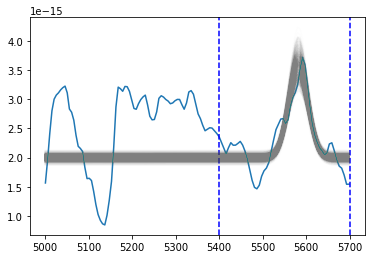

In [14]:
idx = np.logical_and(spec['restwave'] > 5000, spec['restwave'] < 5700)
plt.plot(spec['restwave'][idx], spec['flux'][idx])

plt.axvline(cfg.start5577, color='blue', ls='--')
plt.axvline(cfg.stop5577, color='blue', ls='--')

extra_idx = cfg.extra_lines <= 6000

#modfunc = np.vectorize(oxygen.generation_func_5577)

for i in range(1000):
    p = new_samples[i*7]
    #oxygen_mass = np.exp(p[0])
    oxygen_mass = p[0]
    lte_temp = p[1]

    line_width = p[2]
    #line_skew = p[12]

    continuum_level_5577 = p[3]/cfg.scale_factor
    continuum_level_6300_6364 = p[4]/cfg.scale_factor

    continuum_slope_5577 = p[5]/cfg.scale_factor
    continuum_slope_6300_6364 = p[6]/cfg.scale_factor

    distance = p[7]

    wlen_offset = p[8]

    line_ratio = p[9]

    fluxes = oxygen.create_fluxes(p)
    #fluxes = create_fluxes(p)
    
    amplitude_5577 = fluxes[0]
    amplitude_6300 = fluxes[1]
    amplitude_6364 = fluxes[2]
    
    modflux = np.empty(len(spec['restwave'][idx]))
    for j in range(len(modflux)):
        modflux[j] = oxygen.generation_func_5577(spec['restwave'][idx][j]+wlen_offset, continuum_level_5577, continuum_slope_5577, amplitude_5577, line_width, cfg.extra_lines[extra_idx], extra_lines_amps[extra_idx])
    #modflux = modfunc(spec['restwave'][idx]+wlen_offset, continuum_level_5577, continuum_slope_5577, amplitude_5577, line_width, cfg.extra_lines[extra_idx], extra_lines_amps[extra_idx])
    plt.plot(spec['restwave'][idx], modflux, alpha=0.01, color='grey')

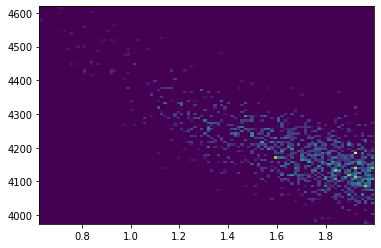

In [15]:
idx = new_samples[:,0] < 2
plt.hist2d(new_samples[:,0][idx], new_samples[:,1][idx], bins=100);
plt.axvline(0.3)

In [16]:
np.percentile(new_samples[:,0], 13)

2.3538224012829807

In [17]:
new_samples[:,3]/cfg.scale_factor

array([2.06696317e-15, 1.97321161e-15, 1.99522301e-15, ...,
       1.98252021e-15, 2.00147693e-15, 1.99530957e-15])

In [18]:

with shelve.open('2022-04-06-oxygen-comparison-nlte-15msun.shelf') as db:
    for fname in glob.glob('../data/comparison/Jerkstrand2014/15msun/*d.dat'):
        # template: ../data/comparison/Jerkstrand2014/15msun/mzams15_306d.dat
        print(os.path.basename(fname))
        base_name = os.path.basename(fname)
        if base_name in db:
            continue
        s = table.Table.read(fname, format='ascii')
        s['restwave'] = s['col1'] + 15
        s['flux'] = s['col2']
        spec = s[~np.isnan(s['flux'])]
        cfg = oxygen.FitSetup(spec=spec, smp=1, start5577=5400, stop5577=5700, start6300_6364=6200, stop6300_6364=6420, extra_lines=np.array([]), max_width=25, scale_factor=1e18, max_continuum=1e-14, nlte_mode=1, nlte_departure_max=0.1)
        dist_mpc = 5.5
        dist_mpc_err = 0.1
        dist_min = (dist_mpc-dist_mpc_err) * u.pc.to(u.cm) * 1e6
        dist_max = (dist_mpc+dist_mpc_err) * u.pc.to(u.cm) * 1e6
        dist_range = (dist_min, dist_max)
        #redshift2distance = utils.redshift2distance
        results, samples = oxygen.run_dynesty_fit(cfg, dist_range=dist_range)
        db[base_name] = {'results': results, 'samples': samples, 'spec': spec}
        
with shelve.open('2022-04-06-oxygen-comparison-15msun.shelf') as db:
    for fname in glob.glob('../data/comparison/Jerkstrand2014/15msun/*d.dat'):
        # template: ../data/comparison/Jerkstrand2014/15msun/mzams15_306d.dat
        print(os.path.basename(fname))
        base_name = os.path.basename(fname)
        if base_name in db:
            continue
        s = table.Table.read(fname, format='ascii')
        s['restwave'] = s['col1'] + 15
        s['flux'] = s['col2']
        spec = s[~np.isnan(s['flux'])]
        cfg = oxygen.FitSetup(spec=spec, smp=1, start5577=5400, stop5577=5700, start6300_6364=6200, stop6300_6364=6420, extra_lines=np.array([]), max_width=25, scale_factor=1e18, max_continuum=1e-14, nlte_mode=0, nlte_departure_max=0.1)
        dist_mpc = 5.5
        dist_mpc_err = 0.1
        dist_min = (dist_mpc-dist_mpc_err) * u.pc.to(u.cm) * 1e6
        dist_max = (dist_mpc+dist_mpc_err) * u.pc.to(u.cm) * 1e6
        dist_range = (dist_min, dist_max)
        #redshift2distance = utils.redshift2distance
        results, samples = oxygen.run_dynesty_fit(cfg, dist_range=dist_range)
        db[base_name] = {'results': results, 'samples': samples, 'spec': spec}

598it [00:00, 5976.19it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 813 | eff(%): 32.984 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.128 | dlogz:    inf >  0.010]

mzams15_212d.dat


43224it [05:09, 139.48it/s, batch: 5 | bound: 334 | nc: 25 | ncall: 1005966 | eff(%):  4.297 | loglstar: -586.711 < -580.002 < -581.392 | logz: -607.111 +/-  0.216 | stop:  0.905]      


	Mean: array([ 2.69087190e+00,  7.27764714e+03,  2.28854779e+01,  2.77770762e+03,
        2.43444009e+03, -1.57371220e-03,  2.59366443e-04,  1.69813599e+25,
       -4.72925092e+00,  4.37221163e+00, -2.19812295e+00,  5.83390863e-01])
	Cov: array([[ 2.12617685e+00, -5.42881482e+02,  6.45141723e-02,
		        -2.32615902e+00, -5.65597382e+00,  1.51466273e-03,
		         5.20629690e-04, -1.42055295e+22, -5.57897074e-02,
		         6.42223488e-01,  6.09895237e-03,  1.61123713e-02],
		       [-5.42881482e+02,  3.03512360e+06, -4.78255700e+01,
		         1.86732924e+02,  1.23704790e+04, -1.86683512e+00,
		         1.85953680e-01,  2.65821347e+25, -6.99055896e+01,
		         1.15778622e+03, -9.49822192e+00, -5.18767660e+01],
		       [ 6.45141723e-02, -4.78255700e+01,  1.12949923e+00,
		        -9.04095065e+00, -3.74289477e+01, -8.18916108e-05,
		         1.45676107e-04, -4.53411406e+21, -2.36741246e-01,
		         8.27753112e-03, -7.18534424e-03,  3.12820997e-03],
		       [-2.32615902e+00,  

570it [00:00, 5698.06it/s, batch: 0 | bound: 0 | nc: 2 | ncall: 765 | eff(%): 32.295 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.128 | dlogz:    inf >  0.010]

mzams15_250d.dat


44082it [05:16, 139.07it/s, batch: 5 | bound: 330 | nc: 25 | ncall: 1030374 | eff(%):  4.278 | loglstar: -563.155 < -556.439 < -557.854 | logz: -585.166 +/-  0.224 | stop:  0.930]      


	Mean: array([ 2.56063850e+00,  6.79290951e+03,  2.22760720e+01,  2.00386856e+03,
        1.75975368e+03, -1.90928866e-03,  6.83270261e-04,  1.69645417e+25,
       -4.69059561e+00,  3.96892595e+00, -2.21935464e+00,  6.74930301e-01])
	Cov: array([[ 2.51465369e+00, -8.79587941e+02, -1.96487676e-01,
		        -6.15263028e+00,  6.66776526e+00, -7.73964285e-04,
		         8.90694885e-04, -8.35828318e+22,  2.95012255e-02,
		         7.42807982e-01, -6.52511466e-03,  1.67142619e-02],
		       [-8.79587941e+02,  2.69331904e+06,  1.03200432e+02,
		         4.63329211e+03, -6.10479797e+03,  4.67490639e-01,
		        -4.46546707e-01,  4.22382945e+25, -9.44959203e+01,
		         9.03747377e+02,  1.14345377e+01, -6.33462612e+01],
		       [-1.96487676e-01,  1.03200432e+02,  8.16193006e-01,
		        -4.67748398e+00, -2.41744876e+01,  3.52346812e-04,
		        -1.25001838e-04,  1.25664801e+22, -5.33514566e-02,
		        -3.33258283e-02,  5.20534481e-03, -3.20464503e-03],
		       [-6.15263028e+00,  

578it [00:00, 5776.78it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 788 | eff(%): 32.327 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.128 | dlogz:    inf >  0.010]

mzams15_306d.dat


43289it [05:10, 139.40it/s, batch: 5 | bound: 323 | nc: 25 | ncall: 1013631 | eff(%):  4.271 | loglstar: -547.897 < -540.942 < -542.841 | logz: -568.383 +/-  0.216 | stop:  0.981]      


	Mean: array([ 2.55344457e+00,  6.09039952e+03,  2.06244158e+01,  1.06999933e+03,
        9.15021924e+02,  9.93069242e-04,  3.01726589e-04,  1.69815946e+25,
       -1.32678272e+00,  3.73209901e+00, -1.80786085e+00,  5.81066851e-01])
	Cov: array([[ 2.53363821e+00, -8.85524958e+01,  2.54533141e-03,
		        -1.80570237e+00, -6.01851245e+00, -1.00578498e-03,
		         5.24805328e-05, -3.24750934e+22,  1.00107918e-01,
		         1.17727735e+00,  1.08632401e-03, -8.65958486e-03],
		       [-8.85524958e+01,  3.04243617e+06, -1.09747219e+01,
		        -1.89820184e+03, -4.28085306e+03,  6.12181180e-02,
		        -4.14628106e-03, -3.27607916e+25,  2.62794787e+02,
		         1.80880667e+03,  5.00034428e+00, -1.37286318e+02],
		       [ 2.54533141e-03, -1.09747219e+01,  9.63331814e-01,
		        -6.12036357e+00, -1.97828468e+01, -2.08190650e-04,
		         1.17457884e-04, -1.11954005e+22,  6.94627964e-02,
		        -1.77094173e-02, -1.39492761e-03,  9.07191165e-03],
		       [-1.80570237e+00, -

555it [00:00, 5547.56it/s, batch: 0 | bound: 0 | nc: 3 | ncall: 781 | eff(%): 31.162 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.128 | dlogz:    inf >  0.010]

mzams15_332d.dat


42974it [04:15, 168.35it/s, batch: 3 | bound: 314 | nc: 25 | ncall: 1041044 | eff(%):  4.128 | loglstar: -526.231 < -519.567 < -523.438 | logz: -548.460 +/-  0.224 | stop:  0.903]      


	Mean: array([ 2.33218609e+00,  6.34702174e+03,  2.09394888e+01,  7.75801253e+02,
        6.70150562e+02,  3.42773065e-04,  9.07842304e-05,  1.69313732e+25,
       -3.85697425e+00,  3.93660105e+00, -1.76065477e+00,  5.81758721e-01])
	Cov: array([[ 2.34211336e+00,  3.47969386e+02,  1.42718519e-01,
		        -2.69487836e+00, -3.77064420e+00, -8.12853116e-04,
		         7.75408325e-04,  2.44670072e+21,  6.41171254e-02,
		         1.39882660e+00,  1.21512265e-02, -3.92740362e-02],
		       [ 3.47969386e+02,  3.98360966e+06,  1.32702617e+02,
		        -1.11178732e+03, -1.13290799e+04, -1.94038729e+00,
		         9.17814348e-01,  4.07913827e+25,  8.75860476e+01,
		         2.40507039e+03,  1.65379945e+01, -1.56155346e+02],
		       [ 1.42718519e-01,  1.32702617e+02,  9.90130069e-01,
		        -4.04950396e+00, -1.52235942e+01, -9.27801391e-05,
		         1.12808110e-04,  1.17622207e+22,  2.19960220e-01,
		         1.73528672e-01,  1.86609878e-03,  1.67579968e-03],
		       [-2.69487836e+00, -

577it [00:00, 5765.19it/s, batch: 0 | bound: 0 | nc: 2 | ncall: 760 | eff(%): 32.784 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.128 | dlogz:    inf >  0.010]

mzams15_350d.dat


43890it [04:47, 152.68it/s, batch: 4 | bound: 331 | nc: 25 | ncall: 1033821 | eff(%):  4.245 | loglstar: -531.982 < -524.447 < -525.986 | logz: -553.741 +/-  0.222 | stop:  0.781]       


	Mean: array([ 1.25373798e+00,  4.57819792e+03,  2.23908396e+01,  7.05270176e+02,
        5.17644616e+02,  6.13836324e-04, -1.11822636e-03,  1.69577175e+25,
       -2.72999874e+00,  1.87910820e+00, -1.58027400e+00,  6.30104826e-01])
	Cov: array([[ 1.17114306e+00,  4.46627448e+01, -1.42401155e-01,
		         1.09685128e+00,  1.19424935e+00,  7.02769000e-04,
		        -1.79441838e-04,  3.30030770e+22,  8.04156156e-01,
		         7.43121898e-01,  1.46971838e-02,  1.86875408e-02],
		       [ 4.46627448e+01,  1.18646014e+06, -1.26387885e+02,
		        -4.15436798e+01,  9.16879542e+02,  1.82122629e-01,
		         7.27833163e-01,  1.20994000e+25,  4.72203194e+02,
		         8.49981068e+02,  7.80325288e+00, -1.41766678e+02],
		       [-1.42401155e-01, -1.26387885e+02,  1.12646522e+00,
		        -3.37642135e+00, -1.92092166e+01, -1.42489656e-05,
		        -3.87267427e-04, -7.27754681e+21, -1.97640840e-01,
		        -1.80579998e-01, -6.35148261e-03,  2.06220575e-02],
		       [ 1.09685128e+00, -

552it [00:00, 5517.60it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 767 | eff(%): 31.239 | loglstar:   -inf < -917095.404 <    inf | logz: -917103.557 +/-  0.128 | dlogz: 918954.922 >  0.010]

mzams15_369d.dat


43708it [04:53, 148.84it/s, batch: 4 | bound: 334 | nc: 25 | ncall: 1052354 | eff(%):  4.153 | loglstar: -501.977 < -494.497 < -496.341 | logz: -524.749 +/-  0.226 | stop:  0.947]        


	Mean: array([ 1.09662050e+00,  3.86448280e+03,  2.13512879e+01,  5.28132162e+02,
        3.86315423e+02,  2.99580170e-03, -9.05315857e-04,  1.70512319e+25,
       -5.30520241e+00,  1.25025158e+00, -1.62442124e+00,  7.33834704e-01])
	Cov: array([[ 5.26595203e-01, -1.48422771e+02, -1.36287062e-03,
		         1.74989825e+00, -2.05186405e+00,  4.42449903e-05,
		         1.50098293e-04, -1.31450824e+22,  1.02460967e-01,
		         1.57189845e-01,  5.98455275e-03,  4.13478739e-02],
		       [-1.48422771e+02,  2.02143523e+05, -1.98773216e+00,
		        -1.14292895e+03,  3.98033842e+02, -1.27543350e-01,
		        -5.08392700e-02,  5.86913128e+24,  9.09013540e+01,
		         9.56804995e+01,  5.67419731e-01, -5.08327342e+01],
		       [-1.36287062e-03, -1.98773216e+00,  1.22142546e+00,
		        -1.04060913e+00, -1.29818658e+01, -2.38444625e-04,
		        -1.10657354e-04,  4.30475723e+21, -1.85747499e-02,
		        -2.25573766e-02, -1.94118405e-04,  6.53305723e-03],
		       [ 1.74989825e+00, -

589it [00:00, 5887.76it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 823 | eff(%): 32.309 | loglstar:   -inf < -625440.243 <    inf | logz: -625448.433 +/-  0.128 | dlogz: 628920.308 >  0.010]

mzams15_400d.dat


43475it [04:22, 165.73it/s, batch: 3 | bound: 333 | nc: 25 | ncall: 1038486 | eff(%):  4.186 | loglstar: -479.089 < -471.159 < -473.498 | logz: -501.846 +/-  0.226 | stop:  0.951]        


	Mean: array([ 1.18520578e+00,  3.72348914e+03,  2.04849881e+01,  3.68943259e+02,
        2.57301175e+02,  1.48461221e-03, -7.40451657e-04,  1.68960019e+25,
       -5.52476354e+00,  9.08499539e-01, -1.49548639e+00,  4.42036488e-01])
	Cov: array([[ 1.13838232e+00, -4.68789994e+02, -6.71357791e-02,
		         5.83075842e+00, -1.88225662e+00, -1.21424858e-03,
		         6.51837888e-04,  4.48089631e+22, -1.01979091e-01,
		         8.12521535e-02,  1.46875630e-02, -3.91886091e-02],
		       [-4.68789994e+02,  4.86420668e+05,  8.74734700e+01,
		        -3.76657847e+03,  5.64127778e+01,  9.89608485e-01,
		        -6.12068995e-01, -2.77710102e+25,  2.03090366e+02,
		         1.17588007e+02, -2.07913231e+00, -2.34256170e+01],
		       [-6.71357791e-02,  8.74734700e+01,  1.10903858e+00,
		        -1.64078626e+00, -8.71996689e+00, -3.46944441e-05,
		        -2.26922183e-04, -2.04384902e+22,  1.05312323e-02,
		        -1.84544143e-02, -1.55531453e-03, -6.17953717e-03],
		       [ 5.83075842e+00, -

568it [00:00, 5675.42it/s, batch: 0 | bound: 0 | nc: 4 | ncall: 778 | eff(%): 31.946 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.128 | dlogz:    inf >  0.010]

mzams15_451d.dat


46635it [05:50, 133.15it/s, batch: 5 | bound: 382 | nc: 25 | ncall: 1122447 | eff(%):  4.155 | loglstar: -437.420 < -430.129 < -432.127 | logz: -459.947 +/-  0.225 | stop:  0.889]       


	Mean: array([ 2.67522200e+00,  2.92257013e+03,  2.08681470e+01,  2.03599517e+02,
        1.32400712e+02,  2.36521845e-03,  2.88125728e-04,  1.70117371e+25,
       -3.69425230e+00,  6.69939143e-01, -1.37155877e+00,  4.70164195e-01])
	Cov: array([[ 2.68433765e+00, -4.89053335e+02, -2.64089828e-02,
		         2.24103780e+00, -5.48179812e-01,  1.05414722e-03,
		         7.40117481e-04, -3.43502350e+22, -1.72124037e-02,
		         1.04527812e-02, -7.31803907e-03, -8.66705383e-03],
		       [-4.89053335e+02,  1.33648475e+05,  5.02031451e+00,
		        -6.07009179e+02, -3.12760523e+01, -1.48277049e-01,
		        -1.40891310e-01,  1.08082513e+25,  3.27414422e+01,
		         2.05622377e+01,  2.34067832e+00, -3.57040662e+00],
		       [-2.64089828e-02,  5.02031451e+00,  1.51281196e+00,
		         2.69345576e-01, -8.28062951e+00,  1.34920127e-05,
		        -1.36240700e-04, -8.48015359e+21, -3.96501383e-01,
		        -2.14601747e-02, -3.49039388e-03,  3.74544931e-03],
		       [ 2.24103780e+00, -

582it [00:00, 5815.82it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 803 | eff(%): 32.280 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.128 | dlogz:    inf >  0.010]

mzams15_212d.dat


44193it [05:55, 124.38it/s, batch: 5 | bound: 376 | nc: 25 | ncall: 1054709 | eff(%):  4.190 | loglstar: -587.723 < -580.521 < -582.309 | logz: -608.631 +/-  0.219 | stop:  0.858]      


	Mean: array([ 4.19547313e+00,  3.77753965e+03,  2.29332989e+01,  2.76688656e+03,
        2.44025457e+03,  1.95670395e-04,  6.58327731e-05,  1.69688107e+25,
       -5.06199186e+00,  2.22195789e+00, -2.20740819e+00,  1.00000000e+00])
	Cov: array([[ 1.13236859e+00, -9.58706053e+01, -9.14638819e-03,
		         3.76076648e+00, -7.40502777e+00,  3.65100847e-06,
		         7.36339567e-06,  9.01139401e+20,  1.25253238e-01,
		         1.56341583e-01, -7.32779382e-03,  1.45048712e-29],
		       [-9.58706053e+01,  1.21567610e+04,  1.29422077e+01,
		        -1.67708949e+03,  4.70971491e+02, -6.54218740e-05,
		        -1.89715180e-03,  8.98253307e+23, -1.23991544e+01,
		        -7.56007608e+00,  5.50430104e-01, -7.26129351e-27],
		       [-9.14638819e-03,  1.29422077e+01,  1.17193015e+00,
		        -8.57492094e+00, -3.95304566e+01,  3.85769676e-05,
		         4.39408195e-05,  2.31315096e+21, -2.83112328e-01,
		        -8.34283857e-03, -5.09713212e-03, -1.27943764e-29],
		       [ 3.76076648e+00, -

570it [00:00, 5693.15it/s, batch: 0 | bound: 0 | nc: 4 | ncall: 809 | eff(%): 31.509 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.128 | dlogz:    inf >  0.010]

mzams15_250d.dat


43671it [05:17, 137.58it/s, batch: 4 | bound: 356 | nc: 25 | ncall: 1047475 | eff(%):  4.169 | loglstar: -563.517 < -556.610 < -558.025 | logz: -585.964 +/-  0.225 | stop:  0.926]      


	Mean: array([ 3.74983289e+00,  3.92922388e+03,  2.24149890e+01,  1.99752009e+03,
        1.75675719e+03,  3.68077108e-04,  4.30166936e-05,  1.69733326e+25,
       -4.84164320e+00,  2.27893658e+00, -2.22796220e+00,  1.00000000e+00])
	Cov: array([[ 1.38619062e+00, -1.28068010e+02, -6.43093722e-03,
		         1.92218118e+00, -2.96383722e+00, -7.81867758e-05,
		        -6.04856761e-05, -1.04361460e+21,  2.04337415e-01,
		         2.35123563e-01, -5.82166833e-03, -4.60597799e-29],
		       [-1.28068010e+02,  1.50392054e+04,  9.82680445e+00,
		        -9.66808789e+02,  3.27353534e+02,  1.33282485e-02,
		         9.28739738e-03,  1.13489336e+24, -1.53233986e+01,
		        -1.88533119e+01,  5.83250635e-01, -1.07060795e-26],
		       [-6.43093722e-03,  9.82680445e+00,  9.50040694e-01,
		        -8.47157011e+00, -2.75308790e+01, -6.13970612e-05,
		         5.62770624e-05,  6.58763499e+20, -6.96476116e-02,
		        -2.69393548e-03, -1.58675264e-03, -1.44387259e-28],
		       [ 1.92218118e+00, -

511it [00:00, 5107.19it/s, batch: 0 | bound: 0 | nc: 2 | ncall: 666 | eff(%): 30.672 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.127 | dlogz:    inf >  0.010]

mzams15_306d.dat


44159it [05:35, 131.77it/s, batch: 5 | bound: 363 | nc: 25 | ncall: 1060213 | eff(%):  4.165 | loglstar: -547.136 < -540.047 < -541.678 | logz: -568.115 +/-  0.219 | stop:  0.836]       


	Mean: array([ 2.29552044e+00,  3.79704732e+03,  2.08076435e+01,  1.06999846e+03,
        9.13806446e+02,  5.59294791e-04,  3.73129731e-05,  1.69856561e+25,
       -2.08668158e+00,  1.74623967e+00, -1.83145329e+00,  1.00000000e+00])
	Cov: array([[ 1.20706471e+00, -1.51242486e+02, -4.53456366e-02,
		         2.92111934e+00, -3.26396073e+00, -1.08720726e-04,
		        -1.71876150e-04,  1.13208979e+22,  4.91895832e-01,
		         3.02328877e-01,  1.49505465e-04, -3.53704223e-29],
		       [-1.51242486e+02,  2.40746102e+04,  1.59831366e+01,
		        -1.05114567e+03,  4.44272592e+02,  5.19059736e-03,
		         2.28179671e-02, -3.55264624e+23, -5.80116338e+01,
		        -3.64510369e+01,  1.17125074e-01,  9.39042640e-26],
		       [-4.53456366e-02,  1.59831366e+01,  1.00437130e+00,
		        -4.74887076e+00, -2.07271940e+01,  2.87274025e-05,
		         6.88313171e-05,  2.40894141e+21, -4.78749622e-02,
		        -8.38504317e-03, -1.27467245e-05,  2.21152212e-28],
		       [ 2.92111934e+00, -

580it [00:00, 5794.65it/s, batch: 0 | bound: 0 | nc: 6 | ncall: 835 | eff(%): 31.608 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.128 | dlogz:    inf >  0.010]

mzams15_332d.dat


45686it [05:18, 143.29it/s, batch: 4 | bound: 369 | nc: 25 | ncall: 1093942 | eff(%):  4.176 | loglstar: -523.727 < -516.692 < -518.204 | logz: -547.619 +/-  0.231 | stop:  0.815]       


	Mean: array([ 1.29991036e+00,  3.91645387e+03,  2.09755933e+01,  7.77325939e+02,
        6.67833497e+02,  1.34462245e-04,  1.29744918e-04,  1.69983914e+25,
       -5.06695053e+00,  1.46597766e+00, -1.79959760e+00,  1.00000000e+00])
	Cov: array([[ 6.27748572e-01, -1.07638777e+02, -3.02737359e-02,
		         8.84374934e-01, -2.34640930e+00, -3.18039718e-04,
		        -4.87585762e-06,  2.02227602e+21,  2.81777348e-01,
		         2.15409100e-01,  5.85094474e-03,  2.14380718e-29],
		       [-1.07638777e+02,  2.53156073e+04,  1.60836094e+01,
		        -7.10876202e+02,  6.13068942e+02,  7.20984535e-02,
		        -2.20113984e-03,  1.37182928e+24, -4.70946238e+01,
		        -3.89555489e+01, -9.87252819e-01,  7.36076666e-26],
		       [-3.02737359e-02,  1.60836094e+01,  9.04672788e-01,
		        -3.68587469e+00, -1.34322148e+01, -1.88883651e-04,
		         2.66422336e-05,  5.35852279e+21,  5.10813401e-03,
		        -6.45772117e-03, -8.82450005e-04, -4.20143807e-31],
		       [ 8.84374934e-01, -

584it [00:00, 5838.07it/s, batch: 0 | bound: 0 | nc: 2 | ncall: 782 | eff(%): 32.772 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.128 | dlogz:    inf >  0.010]

mzams15_350d.dat


42547it [05:04, 139.82it/s, batch: 4 | bound: 335 | nc: 25 | ncall: 1019527 | eff(%):  4.173 | loglstar: -531.255 < -524.435 < -525.996 | logz: -553.766 +/-  0.225 | stop:  0.959]      


	Mean: array([ 2.02496852e+00,  3.60549667e+03,  2.24399002e+01,  7.05619785e+02,
        5.16683889e+02,  1.30221956e-03,  3.25272750e-04,  1.69679332e+25,
       -3.12800415e+00,  1.36695098e+00, -1.59906309e+00,  1.00000000e+00])
	Cov: array([[ 1.15119622e+00, -1.42900513e+02, -6.24034239e-02,
		         1.73881597e+00, -3.66826372e+00,  2.50353793e-04,
		        -8.25714939e-05, -1.45616869e+21,  7.58727421e-01,
		         3.06177036e-01,  9.05515325e-03,  7.88969035e-31],
		       [-1.42900513e+02,  2.50626764e+04,  2.08199613e+01,
		        -9.69586833e+02,  3.97411715e+02, -1.29702450e-02,
		         1.15925815e-02,  1.66170604e+24, -7.52109491e+01,
		        -3.24223774e+01, -1.31730346e+00,  9.50830001e-27],
		       [-6.24034239e-02,  2.08199613e+01,  1.21039134e+00,
		        -2.65896602e+00, -1.76493869e+01, -1.28119599e-06,
		         7.67215934e-05,  2.52541843e+21, -3.98698535e-02,
		        -8.77241721e-03, -2.03145851e-03,  5.80511955e-29],
		       [ 1.73881597e+00, -

553it [00:00, 5523.83it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 744 | eff(%): 31.709 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.128 | dlogz:    inf >  0.010]

mzams15_369d.dat


46791it [06:05, 128.03it/s, batch: 5 | bound: 393 | nc: 25 | ncall: 1124653 | eff(%):  4.160 | loglstar: -502.292 < -494.632 < -496.663 | logz: -525.166 +/-  0.227 | stop:  0.912]      


	Mean: array([ 1.72235058e+00,  3.47578860e+03,  2.13048859e+01,  5.27012967e+02,
        3.87426931e+02,  1.16482456e-03,  7.64235823e-05,  1.69785332e+25,
       -5.39356142e+00,  1.16170358e+00, -1.63269435e+00,  1.00000000e+00])
	Cov: array([[ 6.95346510e-01, -1.10975144e+02, -6.04382656e-02,
		         2.46373728e+00, -1.38497810e+00, -1.98281591e-04,
		        -1.59369117e-04, -2.24077706e+21,  2.38107780e-01,
		         1.70299706e-01,  7.77124780e-03,  8.66134385e-30],
		       [-1.10975144e+02,  2.46822509e+04,  1.92294455e+01,
		        -9.24898640e+02,  7.61524567e+01,  5.74754542e-02,
		         3.05284293e-02,  1.37015148e+24, -1.61434968e+01,
		        -1.92491520e+01, -1.34325377e+00, -2.31049671e-26],
		       [-6.04382656e-02,  1.92294455e+01,  1.12599027e+00,
		        -1.46161119e+00, -1.28377163e+01,  2.13044656e-05,
		         6.58109400e-05,  7.56372607e+21, -1.48807778e-02,
		        -8.42509121e-03,  8.14670334e-04, -4.06670162e-28],
		       [ 2.46373728e+00, -

585it [00:00, 5847.45it/s, batch: 0 | bound: 0 | nc: 3 | ncall: 807 | eff(%): 32.374 | loglstar:   -inf < -819148.276 <    inf | logz: -819156.462 +/-  0.128 | dlogz: 833808.039 >  0.010]

mzams15_400d.dat


46095it [05:59, 128.09it/s, batch: 5 | bound: 373 | nc: 25 | ncall: 1104709 | eff(%):  4.173 | loglstar: -478.669 < -471.283 < -473.143 | logz: -501.406 +/-  0.227 | stop:  0.861]        


	Mean: array([ 2.37225465e+00,  3.13648823e+03,  2.05775816e+01,  3.66826870e+02,
        2.52624795e+02,  1.07089421e-03,  5.52837344e-05,  1.69683377e+25,
       -5.77978467e+00,  8.68510383e-01, -1.51762693e+00,  1.00000000e+00])
	Cov: array([[ 1.58242909e+00, -2.37296178e+02, -6.05808225e-02,
		         5.20794409e+00, -1.73532995e+00, -9.99135334e-05,
		         1.54502618e-04,  9.18458241e+21,  6.09518346e-02,
		         1.03641633e-01,  4.86880784e-03, -7.38273512e-29],
		       [-2.37296178e+02,  4.30719804e+04,  1.21960591e+01,
		        -1.05732791e+03,  1.20370229e+02,  4.10392735e-02,
		        -2.33136244e-02, -3.72324712e+22,  8.56374335e+00,
		        -4.33177198e+00, -6.52235289e-01, -5.10794418e-26],
		       [-6.05808225e-02,  1.21960591e+01,  1.13944536e+00,
		        -6.79850570e-01, -9.42987106e+00, -2.53968372e-05,
		         1.47974804e-05, -1.88772205e+20, -1.45469342e-02,
		        -8.55362190e-03, -3.26319040e-04, -3.72318907e-28],
		       [ 5.20794409e+00, -

589it [00:00, 5886.33it/s, batch: 0 | bound: 0 | nc: 3 | ncall: 807 | eff(%): 32.595 | loglstar:   -inf < -647391.567 <    inf | logz: -647399.756 +/-  0.128 | dlogz: 658326.360 >  0.010]

mzams15_451d.dat


39233it [03:47, 172.40it/s, batch: 2 | bound: 299 | nc: 25 | ncall: 935297 | eff(%):  4.195 | loglstar: -435.560 < -430.153 < -432.653 | logz: -459.616 +/-  0.229 | stop:  0.975]         


	Mean: array([ 2.74882189e+00,  2.84212725e+03,  2.10163449e+01,  2.01408322e+02,
        1.31802515e+02,  2.38518823e-03, -1.73014553e-04,  1.69766783e+25,
       -3.61588692e+00,  6.67505528e-01, -1.38303374e+00,  1.00000000e+00])
	Cov: array([[ 1.88928146e+00, -2.52880614e+02, -3.16447774e-04,
		         2.51335155e+00,  3.94819975e-01, -1.92567964e-04,
		         3.69748779e-04,  2.94952466e+20, -2.59734539e-01,
		         1.35980964e-02, -8.19606859e-04,  8.28190734e-29],
		       [-2.52880614e+02,  4.00669466e+04,  2.11678984e+00,
		        -4.40558442e+02, -1.38260519e+02,  2.68456584e-02,
		        -5.57108540e-02,  8.25151644e+23,  5.82947012e+01,
		         6.91340571e+00,  3.67175058e-01, -9.54589054e-26],
		       [-3.16447774e-04,  2.11678984e+00,  1.56793671e+00,
		        -9.29732658e-03, -8.26803002e+00,  5.52761279e-05,
		         3.88104744e-05,  6.11605389e+20, -4.42236502e-01,
		        -1.08253207e-02, -2.71869100e-03,  3.17840395e-28],
		       [ 2.51335155e+00, -

In [19]:
def stats_fluxes(samples):
    ret = {}
    for i,l in enumerate([5577, 6300, 6364]):
        p = np.empty(500)
        for j in range(500):
            p[j] = oxygen.create_fluxes(samples[j*500 % len(samples)])[i]
        mean = np.mean(p)
        std = np.std(p)
        ret[l] = (mean,std)
    return ret

def load_file(fname_db):
    param_t = {}
    param_t['phase'] = []
    param_t['mass'] = []
    param_t['temp'] = []
    param_t['tau'] = []
    param_t['mass_err'] = []
    param_t['mass_err_p'] = []
    param_t['mass_err_n'] = []
    param_t['temp_err'] = []
    param_t['tau_err'] = []
    for line in [5577, 6300, 6364]:
        param_t['flux_%d' % line] = []
        param_t['fluxerr_%d' % line] = []
    
    with shelve.open(fname_db) as db:
        for fname in glob.glob('../data/comparison/Jerkstrand2014/15msun/*d.dat'):
            base_name = os.path.basename(fname)
            if base_name not in db:
                continue
            parts = base_name.split('_')
            phase = int(parts[1].split('d')[0])
            entry = db[base_name]
            param_t['phase'].append(phase)
            results = entry['results']
            samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
            new_samples = dyfunc.resample_equal(samples, weights)
            
            mass_mean = np.mean(new_samples[:,0])
            param_t['mass'].append(mass_mean)
            mass_p = np.percentile(new_samples[:,0], [15.9, 84.1]) - mass_mean
            
            param_t['temp'].append(np.mean(new_samples[:,1]))
            param_t['mass_err'].append(np.std(new_samples[:,0]))
            param_t['mass_err_p'].append(mass_p[1])
            param_t['mass_err_n'].append(mass_p[0])
            
            param_t['temp_err'].append(np.std(new_samples[:,1]))
            param_t['tau'].append(np.mean(new_samples[:,9]))
            param_t['tau_err'].append(np.std(new_samples[:,9]))
            fluxes = stats_fluxes(new_samples)
            for line in [5577, 6300, 6364]:
                param_t['flux_%d' % line].append(fluxes[line][0])
                param_t['fluxerr_%d' % line].append(fluxes[line][1])
    param = table.Table(param_t)
    return param
param_lte = load_file('2022-04-06-oxygen-comparison-15msun.shelf')
param_nlte = load_file('2022-04-06-oxygen-comparison-nlte-15msun.shelf')

In [20]:
param_lte

<Table length=8>
phase        mass        ...       flux_6364             fluxerr_6364     
int64      float64       ...        float64                float64        
----- ------------------ ... ---------------------- ----------------------
  212  4.197335310549114 ... 1.9023776251315618e-13  1.129439283061079e-14
  250 3.7491959911787314 ... 1.9986362726513997e-13   9.08346451977505e-15
  306  2.295604410543272 ... 1.4073991445119968e-13  9.979786972013889e-15
  332 1.3009833390628511 ... 1.1196546718494562e-13  9.265172572115426e-15
  350 2.0235682096178027 ... 1.1162967033540133e-13  1.015801285411592e-14
  369 1.7227646181869916 ...  8.520286827243953e-14  7.318141801642209e-15
  400 2.3732262095217247 ...  6.117059357355973e-14 5.6387867222654185e-15
  451 2.7484194906080077 ...  3.533490995817045e-14   3.01671325565285e-15

In [21]:
param_nlte

<Table length=8>
phase        mass        ...       flux_6364             fluxerr_6364     
int64      float64       ...        float64                float64        
----- ------------------ ... ---------------------- ----------------------
  212 2.6917408898072805 ... 1.9706141294796538e-13 1.1423524748611922e-14
  250 2.5613400621289872 ... 2.0407501719017286e-13  9.563226517960937e-15
  306 2.5506256988676217 ... 1.5233577141622078e-13  9.901105782873835e-15
  332  2.332794204312352 ... 1.2783948972734563e-13  8.122587275587267e-15
  350 1.2568959237241764 ... 1.1622623834556905e-13 1.2378709845931778e-14
  369 1.0962759030790161 ...  8.593481966381754e-14  8.084567125967078e-15
  400  1.183809656472308 ...  6.060961657653209e-14  6.238570898521886e-15
  451 2.6764201990769796 ... 3.5212054663947714e-14 2.9596678598181074e-15

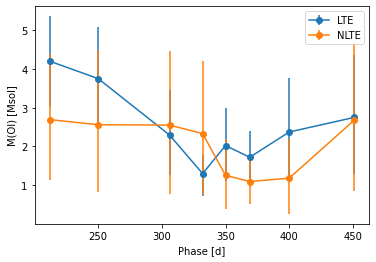

In [41]:
#plt.errorbar(param_lte['phase'], param_lte['mass'], yerr=param_lte['mass_err'], label='LTE', marker='o')
plt.errorbar(param_lte['phase'], param_lte['mass'], yerr=(-param_lte['mass_err_n'], param_lte['mass_err_p']) , label='LTE', marker='o')
#plt.ylim((0,1.5))
plt.errorbar(param_nlte['phase'], param_nlte['mass'], yerr=(-param_nlte['mass_err_n'], param_nlte['mass_err_p']), label='NLTE', marker='o')
#plt.ylim((0,1.5))
plt.legend()
plt.xlabel('Phase [d]')
plt.ylabel('M(OI) [Msol]')
plt.savefig('2022-04-07-oxygen-diag-j14-15msun-moi.png')

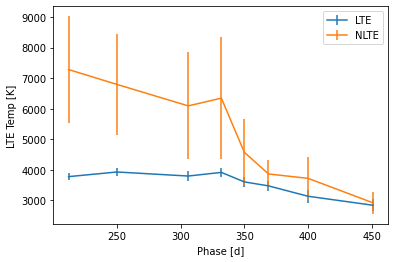

In [23]:
plt.errorbar(param_lte['phase'], param_lte['temp'], yerr=param_lte['temp_err'], label='LTE')
plt.errorbar(param_nlte['phase'], param_nlte['temp'], yerr=param_nlte['temp_err'], label='NLTE')
plt.legend()
plt.xlabel('Phase [d]')
plt.ylabel('LTE Temp [K]')
plt.savefig('2022-04-07-oxygen-diag-j14-15msun-temp.png')

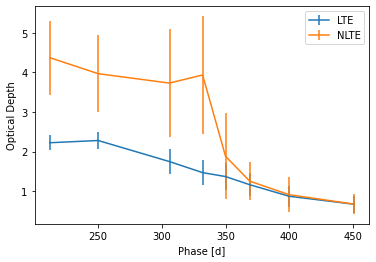

In [24]:
plt.errorbar(param_lte['phase'], param_lte['tau'], yerr=param_lte['tau_err'], label='LTE')
plt.errorbar(param_nlte['phase'], param_nlte['tau'], yerr=param_nlte['tau_err'], label='NLTE')
plt.legend()
plt.xlabel('Phase [d]')
plt.ylabel('Optical Depth')
plt.savefig('2022-04-07-oxygen-diag-j14-15msun-tau.png')

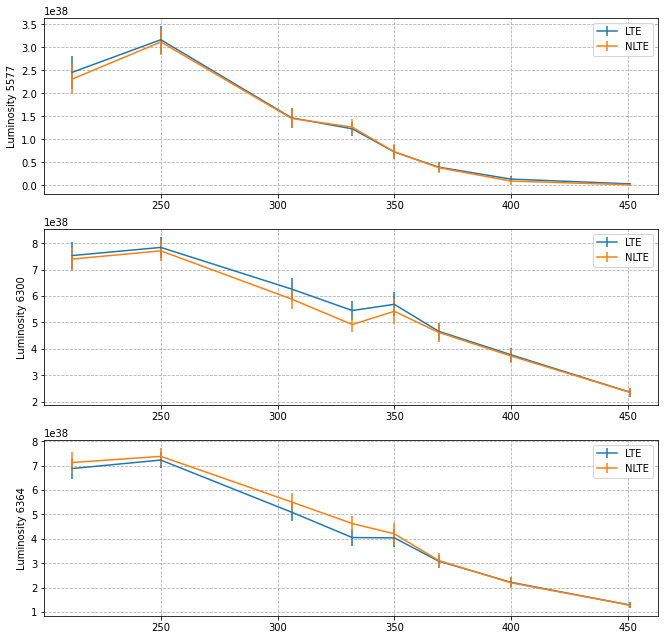

In [25]:
fig, axs = plt.subplots(3, figsize=(11,11))
for i,line in enumerate([5577, 6300, 6364]):
    ax = axs[i]
    ax.set_ylabel('Luminosity %d' % line)
    ax.errorbar(param_lte['phase'], flux2luminosity(param_lte['flux_%d' % line], dist_mpc*1e6*u.pc.to(u.cm)), yerr=flux2luminosity(param_lte['fluxerr_%d' % line], dist_mpc*1e6*u.pc.to(u.cm)), label='LTE')
    ax.errorbar(param_nlte['phase'], flux2luminosity(param_nlte['flux_%d' % line], dist_mpc*1e6*u.pc.to(u.cm)), yerr=flux2luminosity(param_nlte['fluxerr_%d' % line], dist_mpc*1e6*u.pc.to(u.cm)), label='NLTE')
    ax.grid(ls='--')
    ax.legend()
plt.savefig('2022-04-07-oxygen-diag-j14-15msun-lums.png')

In [26]:
def plot_spec(results, spec):
    idx = np.logical_and(spec['restwave'] > 6100, spec['restwave'] < 6500)
    #idx = np.logical_and(spec['restwave'] > 6100, spec['restwave'] < 6200)
    plt.plot(spec['restwave'][idx], spec['flux'][idx])
    #continuum_level_6300_6364 = 0.3e-17
    #continuum_slope_6300_6364 = 0.03/1e18
    #amplitude_6300 = 1.3e-15
    #amplitude_6364 = 0.5e-15
    #line_width = 16
    #modflux = oxygen.generation_func_5577(spec['restwave'][idx], continuum_level_5577, continuum_slope_5577, amplitude_5577, line_width)

    samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    new_samples = dyfunc.resample_equal(samples, weights)
    
    plt.axvline(6300, color='orange')
    plt.axvline(6364, color='orange')
    plt.axvline(6158, color='orange')

    extra_idx = cfg.extra_lines > 6000

    #print(len(new_samples))
    #print(cfg.extra_lines.dtype)
    for i in range(300):
        p = new_samples[(i*38) % len(new_samples)]
        #oxygen_mass = np.exp(p[0])
        p = np.array(p, copy=True)
        #p[0] /= 1.3
        #oxygen_masses[i] = p[0]
    
        line_width = p[2]#*1.3
        wlen_offset = p[8]
        #line_skew = p[12]
        #p[9] -= 3

        continuum_level_5577 = p[3]/cfg.scale_factor
        continuum_level_6300_6364 = p[4]/cfg.scale_factor

        continuum_slope_5577 = p[5]/cfg.scale_factor
        continuum_slope_6300_6364 = p[6]/cfg.scale_factor
    
        extra_lines_amps = np.exp(p[12:])/cfg.scale_factor
        #extra_lines_amps = np.exp([6])/1e17
        #print(extra_lines_amps.dtype)

        fluxes = oxygen.create_fluxes(p)
        #fluxes = create_fluxes(p)
    
        amplitude_5577 = fluxes[0]
        amplitude_6300 = fluxes[1]
        amplitude_6364 = fluxes[2]
    
        #print(spec['restwave'][idx]+wlen_offset)
        modflux = np.empty(len(spec['restwave'][idx]))
        for j in range(len(modflux)):
            modflux[j] = oxygen.generation_func_6300_6364((spec['restwave'][idx]+wlen_offset)[j], continuum_level_6300_6364, continuum_slope_6300_6364, amplitude_6300, amplitude_6364, line_width, cfg.extra_lines[extra_idx], extra_lines_amps[extra_idx])
        plt.plot(spec['restwave'][idx], modflux, alpha=0.01, color='grey')
    plt.axvline(cfg.start6300_6364, color='blue', ls='--')
    plt.axvline(cfg.stop6300_6364, color='blue', ls='--')
    
def plot_spec5577(results, spec):
    idx = np.logical_and(spec['restwave'] > 5000, spec['restwave'] < 5700)
    plt.plot(spec['restwave'][idx], spec['flux'][idx])
    
    samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    new_samples = dyfunc.resample_equal(samples, weights)
    
    plt.axvline(cfg.start5577, color='blue', ls='--')
    plt.axvline(cfg.stop5577, color='blue', ls='--')

    extra_idx = cfg.extra_lines <= 6000
    
    for i in range(1000):
        p = new_samples[i*7]
        #oxygen_mass = np.exp(p[0])
        oxygen_mass = p[0]
        lte_temp = p[1]

        line_width = p[2]
        #line_skew = p[12]

        continuum_level_5577 = p[3]/cfg.scale_factor
        continuum_level_6300_6364 = p[4]/cfg.scale_factor

        continuum_slope_5577 = p[5]/cfg.scale_factor
        continuum_slope_6300_6364 = p[6]/cfg.scale_factor

        distance = p[7]

        wlen_offset = p[8]

        line_ratio = p[9]
        
        extra_lines_amps = np.exp(p[12:])/cfg.scale_factor

        fluxes = oxygen.create_fluxes(p)
        #fluxes = create_fluxes(p)
    
        amplitude_5577 = fluxes[0]
        amplitude_6300 = fluxes[1]
        amplitude_6364 = fluxes[2]
    
        modflux = np.empty(len(spec['restwave'][idx]))
        for j in range(len(modflux)):
            modflux[j] = oxygen.generation_func_5577(spec['restwave'][idx][j]+wlen_offset, continuum_level_5577, continuum_slope_5577, amplitude_5577, line_width, cfg.extra_lines[extra_idx], extra_lines_amps[extra_idx])
            #modflux[j] = oxygen.generation_func_5577(spec['restwave'][idx][j]+wlen_offset, continuum_level_6300_6364, continuum_slope_5577, amplitude_5577, line_width, cfg.extra_lines[extra_idx], extra_lines_amps[extra_idx])
        #modflux = modfunc(spec['restwave'][idx]+wlen_offset, continuum_level_5577, continuum_slope_5577, amplitude_5577, line_width, cfg.extra_lines[extra_idx], extra_lines_amps[extra_idx])
        plt.plot(spec['restwave'][idx], modflux, alpha=0.01, color='grey')

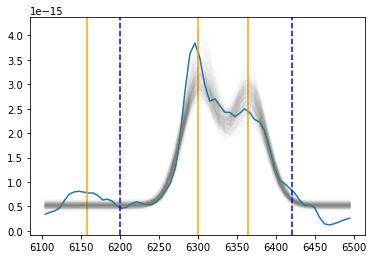

In [27]:
idx = 4
with shelve.open('2022-04-06-oxygen-comparison-nlte-15msun.shelf') as db:
    for i,fname in enumerate(glob.glob('../data/comparison/Jerkstrand2014/15msun/*d.dat')):
        base_name = os.path.basename(fname)
        if i != idx:
            continue
        s = table.Table.read(fname, format='ascii')
        s['restwave'] = s['col1'] + 15
        s['flux'] = s['col2']
        spec = s[~np.isnan(s['flux'])]
        entry = db[base_name]
        results = entry['results']
        plot_spec(results, spec)

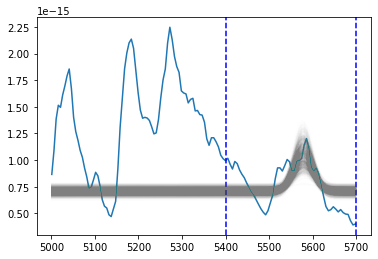

In [28]:
idx = 4
with shelve.open('2022-04-06-oxygen-comparison-nlte-15msun.shelf') as db:
    for i,fname in enumerate(glob.glob('../data/comparison/Jerkstrand2014/15msun/*d.dat')):
        base_name = os.path.basename(fname)
        if i != idx:
            continue
        s = table.Table.read(fname, format='ascii')
        s['restwave'] = s['col1'] + 15
        s['flux'] = s['col2']
        spec = s[~np.isnan(s['flux'])]
        entry = db[base_name]
        results = entry['results']
        plot_spec5577(results, spec)

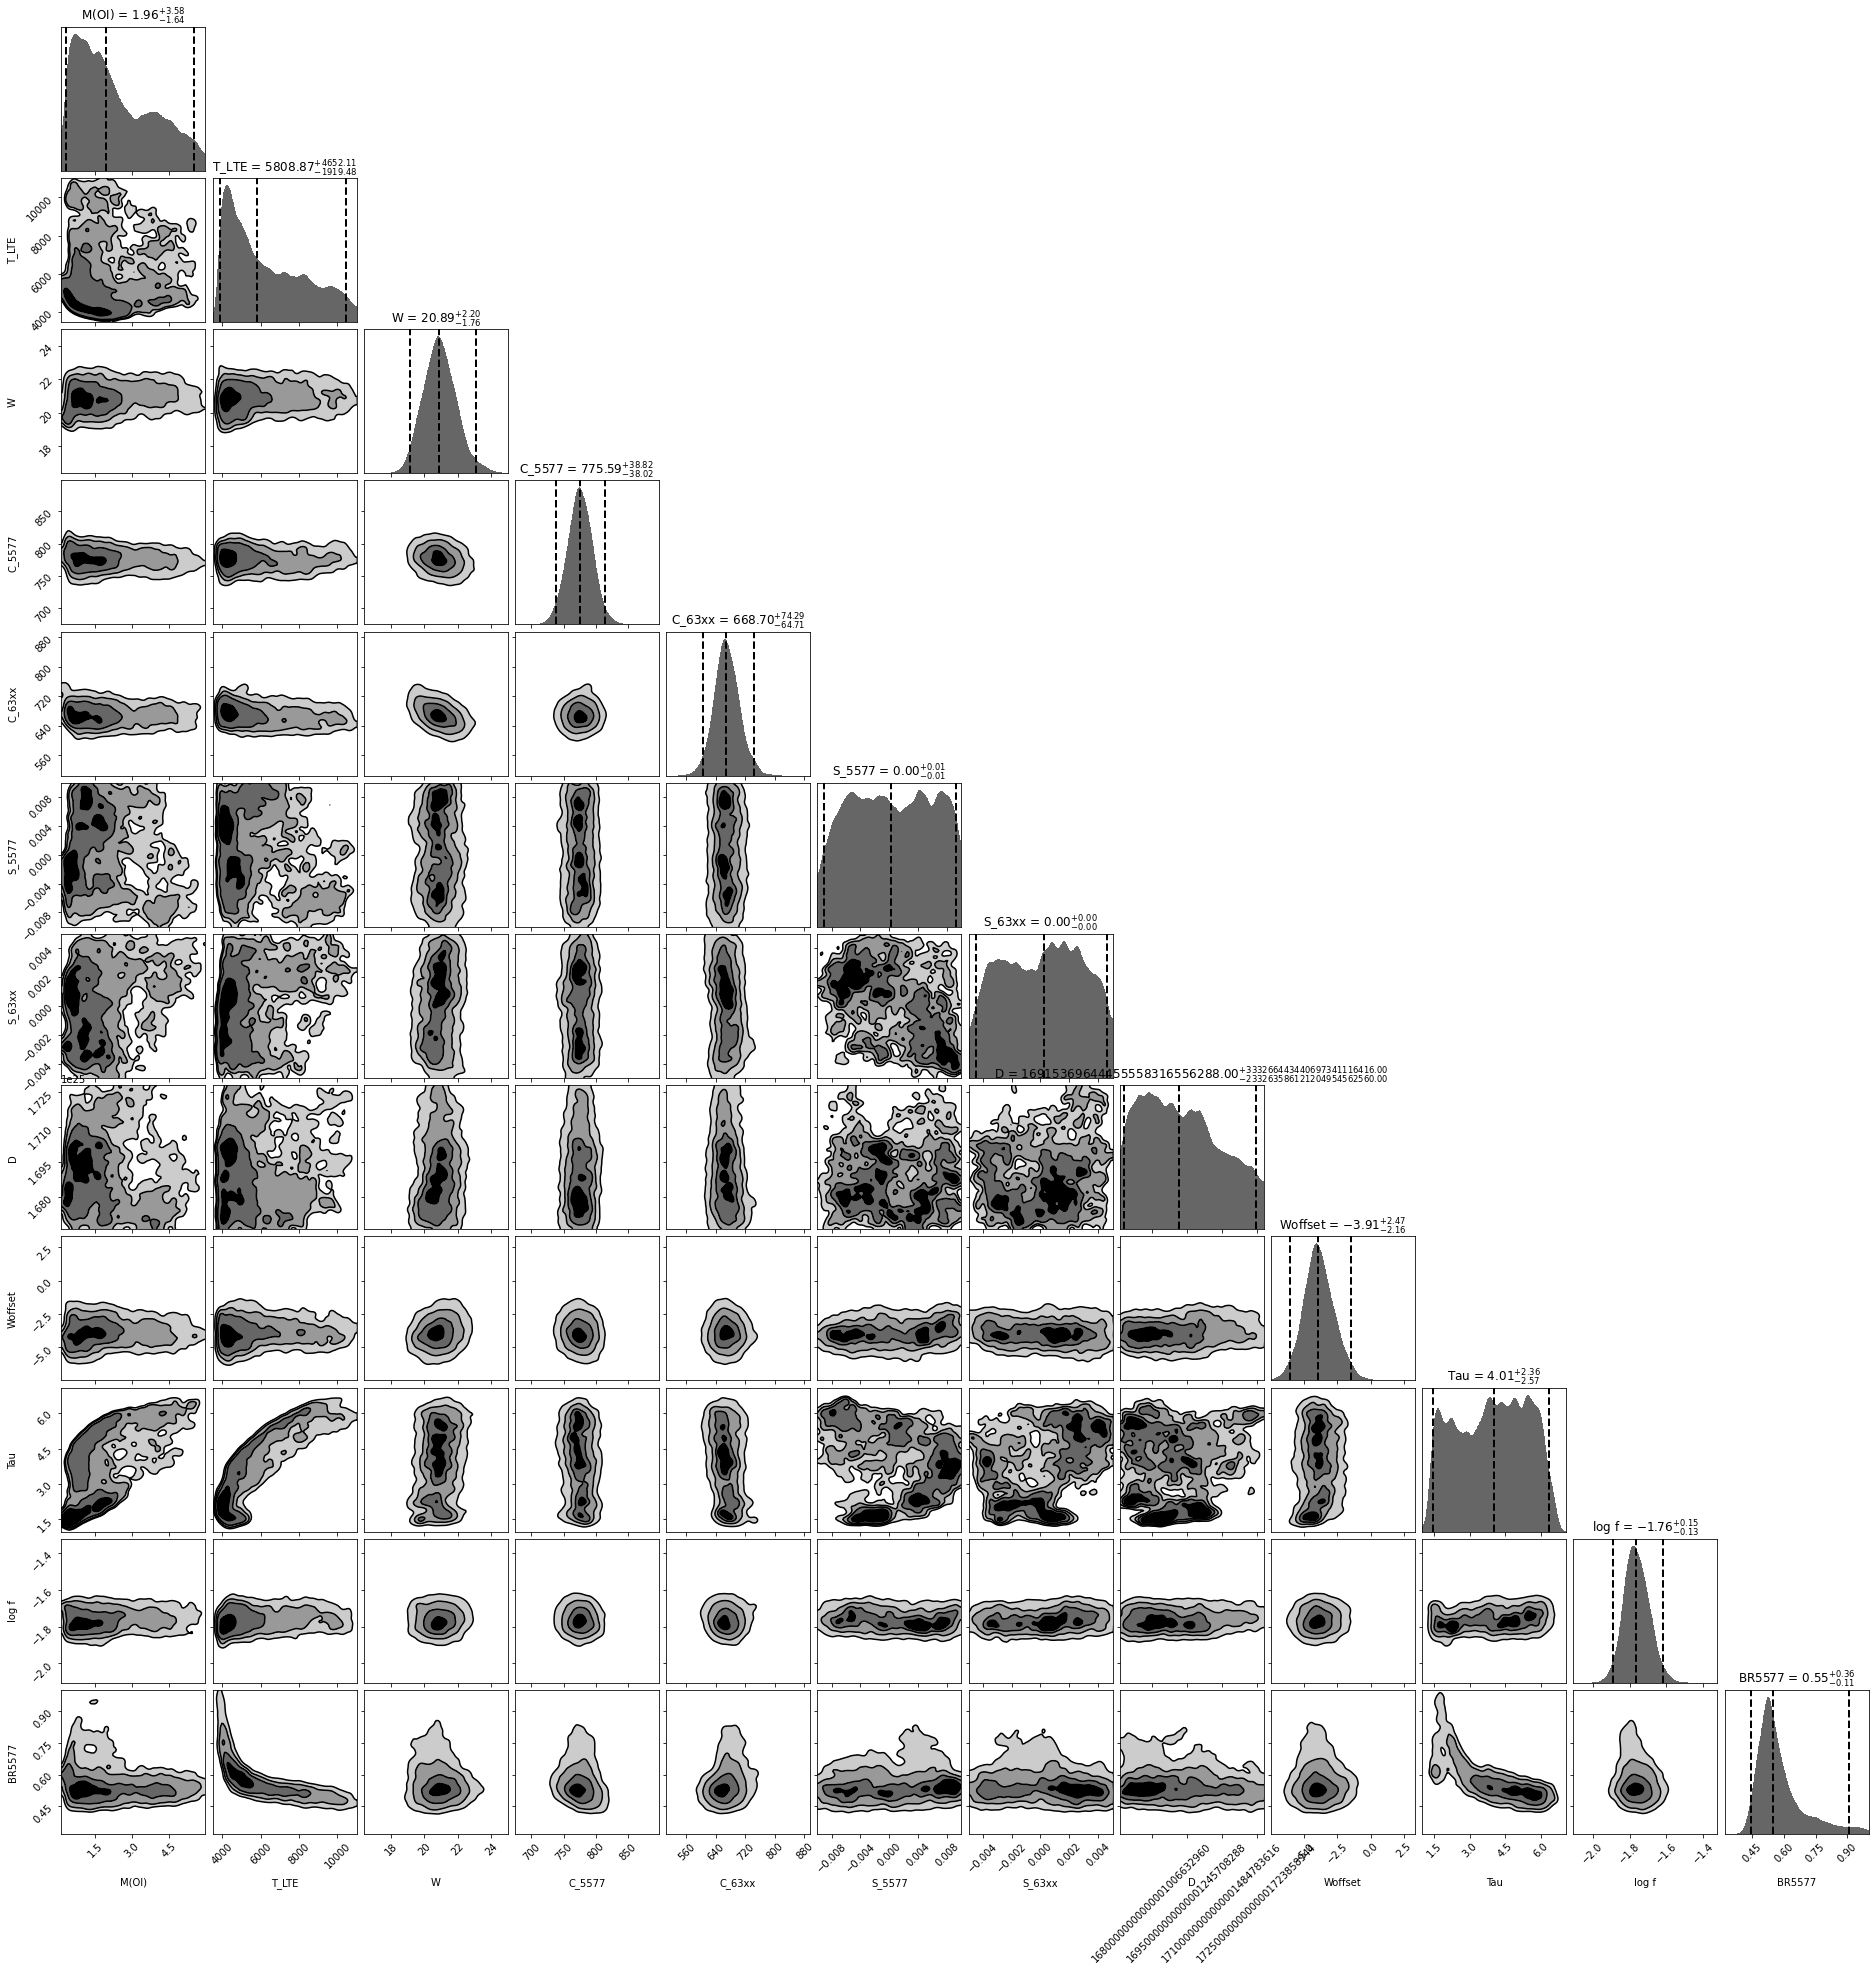

In [29]:
idx = 3
LABELS = ['M(OI)', 'T_LTE', 'W', 'C_5577', 'C_63xx', 'S_5577', 'S_63xx', 'D', 'Woffset', 'Tau', 'log f', 'BR5577', 'AmpE1', 'AmpE2', 'AmpE3', 'AmpE4']
with shelve.open('2022-04-06-oxygen-comparison-nlte-15msun.shelf') as db:
    for i,fname in enumerate(glob.glob('../data/comparison/Jerkstrand2014/15msun/*d.dat')):
        base_name = os.path.basename(fname)
        if i != idx:
            continue
        s = table.Table.read(fname, format='ascii')
        s['restwave'] = s['col1'] + 15
        s['flux'] = s['col2']
        spec = s[~np.isnan(s['flux'])]
        entry = db[base_name]
        results = entry['results']
        #plot_spec(results, spec)
        dyplot.cornerplot(results, labels=LABELS, show_titles=True)

In [30]:
# delete in case we need to rerun it because we made some changes
#!rm 2022-04-06-oxygen-comparison-15msun.shelf*
#!rm 2022-04-06-oxygen-comparison-nlte-15msun.shelf*

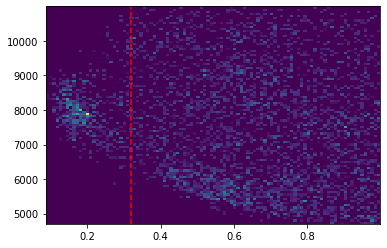

In [31]:
def make_hist(fname_db):
    s_moi = []
    s_t = []
    
    with shelve.open(fname_db) as db:
        for fname in glob.glob('../data/comparison/Jerkstrand2014/15msun/*d.dat'):
            base_name = os.path.basename(fname)
            if base_name not in db:
                continue
            parts = base_name.split('_')
            phase = int(parts[1].split('d')[0])
            entry = db[base_name]
            
            if phase != 250:
                continue
            
            results = entry['results']
            samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
            new_samples = dyfunc.resample_equal(samples, weights)
            idx = new_samples[:,0] < 1
            s_moi.append(new_samples[:,0][idx])
            s_t.append(new_samples[:,1][idx])
    moi = np.concatenate(s_moi)
    t = np.concatenate(s_t)
    plt.hist2d(moi, t, bins=100)
make_hist('2022-04-06-oxygen-comparison-nlte-15msun.shelf')
plt.axvline(0.32, ls='--', color='red')

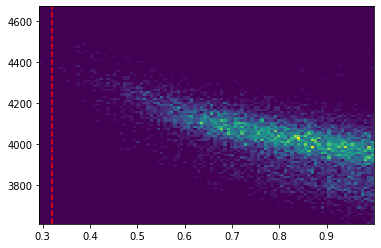

In [32]:
def make_hist(fname_db):
    s_moi = []
    s_t = []
    
    with shelve.open(fname_db) as db:
        for fname in glob.glob('../data/comparison/Jerkstrand2014/15msun/*d.dat'):
            base_name = os.path.basename(fname)
            if base_name not in db:
                continue
            parts = base_name.split('_')
            phase = int(parts[1].split('d')[0])
            entry = db[base_name]
            
            if phase > 350:
                continue
            
            results = entry['results']
            samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
            new_samples = dyfunc.resample_equal(samples, weights)
            idx = new_samples[:,0] < 1
            s_moi.append(new_samples[:,0][idx])
            s_t.append(new_samples[:,1][idx])
    moi = np.concatenate(s_moi)
    t = np.concatenate(s_t)
    plt.hist2d(moi, t, bins=100)
make_hist('2022-04-06-oxygen-comparison-15msun.shelf')
plt.axvline(0.32, ls='--', color='red')

<ipython-input-33-acac246b5d73>:28: UserWarning: No contour levels were found within the data range.
  plt.contour(xbins, ybins, h, levels=[100, 1000], label='%d' % phase)
<ipython-input-33-acac246b5d73>:28: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xbins, ybins, h, levels=[100, 1000], label='%d' % phase)
No handles with labels found to put in legend.


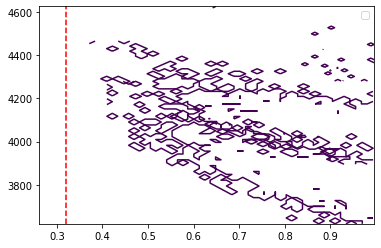

In [33]:
def make_hist(fname_db):
    s_moi = []
    s_t = []
    
    with shelve.open(fname_db) as db:
        for fname in glob.glob('../data/comparison/Jerkstrand2014/15msun/*d.dat'):
            base_name = os.path.basename(fname)
            if base_name not in db:
                continue
            parts = base_name.split('_')
            phase = int(parts[1].split('d')[0])
            entry = db[base_name]
            
            if phase > 350:
                continue
            
            results = entry['results']
            samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
            new_samples = dyfunc.resample_equal(samples, weights)
            idx = new_samples[:,0] < 1
            s_moi.append(new_samples[:,0][idx])
            s_t.append(new_samples[:,1][idx])
            h, xedges, yedges = np.histogram2d(new_samples[:,0][idx], new_samples[:,1][idx], bins=50)
            xbins = xedges[:-1] + (xedges[1] - xedges[0]) / 2
            ybins = yedges[:-1] + (yedges[1] - yedges[0]) / 2
            h = h.T
            levels = 2
            plt.contour(xbins, ybins, h, levels=[100, 1000], label='%d' % phase)
make_hist('2022-04-06-oxygen-comparison-15msun.shelf')
plt.axvline(0.32, ls='--', color='red')
plt.legend()

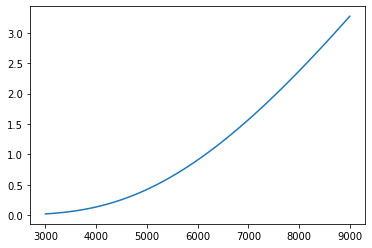

In [34]:
temp = np.linspace(3000, 9000)
tau_6300 = 1.3
tau_5577 = oxygen.calculate_5577_optical_depth(tau_6300, temp)
plt.plot(temp, tau_5577)

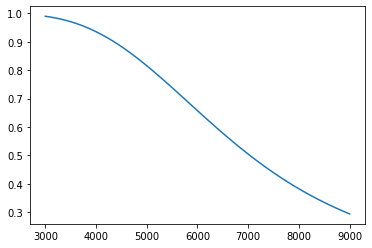

In [35]:
temp = np.linspace(3000, 9000)
tau_6300 = 1.3
tau_5577 = oxygen.calculate_5577_optical_depth(tau_6300, temp)
plt.plot(temp, oxygen.tau_to_beta(tau_5577))

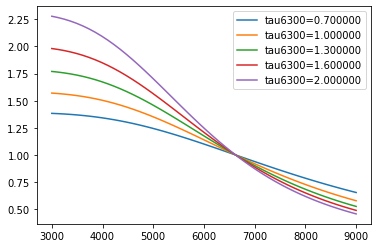

In [36]:
temp = np.linspace(3000, 9000)
for tau_6300 in [0.7, 1.0, 1.3, 1.6, 2.0]:
    #tau_6300 = 1.3
    tau_5577 = oxygen.calculate_5577_optical_depth(tau_6300, temp)
    plt.plot(temp, oxygen.tau_to_beta(tau_5577)/oxygen.tau_to_beta(tau_6300), label='tau6300=%f' % tau_6300)
plt.legend()